# Property Data Analysis and Livability Metric Creation

## Overview
This notebook demonstrates the process of cleaning, transforming, and analyzing property data. Key steps include loading and processing property information, extracting relevant features, handling missing data, and creating a **Livability Metric** based on proximity to amenities.

## Key Steps:
1. **Data Loading**: 
   - Property data is loaded from JSON, Parquet, and CSV formats.
   - **GeoPandas** is used to handle geographical data (e.g., postcodes).
   
2. **Data Cleaning**:
   - Null handling: Missing values in numeric columns are filled with mean values, and categorical columns are filled with default values.
   - Extracting and standardizing property features (e.g., beds, baths, parking, and costs).
   - Handling duplicated entries and invalid data (e.g., parking spaces without proper property descriptions).

3. **Feature Engineering**:
   - Creation of new columns such as **beds**, **baths**, and **parkings** from raw text.
   - **Address parsing**: Decomposing complex addresses into unit, street, suburb, and postal code.
   - One-hot encoding of additional property features for machine learning readiness.

4. **Livability Metric**:
   - A **harmonic sum** method is used to account for diminishing returns of amenity counts.
   - Weighted importance is assigned to amenities (e.g., schools, parks, hospitals).
   - The **livability score** is normalized to a scale of 1-100, allowing easy comparison across properties.

5. **Data Visualization**:
   - **Trend Analysis**: Rental price trends across years, displayed with line plots and heatmaps.
   - **Distribution Analysis**: Box plots and scatter plots for rental price variations across suburbs.

6. **Output**:
   - The cleaned and enriched dataset is saved in Parquet format for future analysis or model training.

Produced with assistance from ChatGPT, powered by OpenAI.

In [1]:
import pyspark, re, json, os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, regexp_extract, lower, explode, array_contains, collect_set, lit, coalesce, array, count, when, isnull, mean, rand
from pyspark.sql.types import IntegerType, StringType, FloatType, StructType, StructField
from pyspark.ml.feature import StringIndexer
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("Melbourne Real Estate")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/11 18:30:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/11 18:30:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Load the data from the JSON file
with open('../data/landing/domain_data.json', 'r') as f:
    data = json.load(f)

# Convert the JSON to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df

,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domain.com.au/1001-39-queen-street-melbourne-vic-3000-17221118,"1001/39 Queen Street, Melbourne VIC 3000",$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning residence in the historic Madiso...,Apartment / Unit / Flat,NaN
https://www.domain.com.au/2817s-220-spencer-street-melbourne-vic-3000-17223080,"2817s/220 Spencer Street, Melbourne VIC 3000",$800 per week,"[2 Beds, 2 Baths]",[1 Parking],"Stunning Furnished Two Bedroom, Two Bathroom a...",Apartment / Unit / Flat,[Furnished]
https://www.domain.com.au/3207-80-a-beckett-street-melbourne-vic-3000-17119770,"3207/80 A'Beckett Street, Melbourne VIC 3000",$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 development gives you the best that t...,Apartment / Unit / Flat,"[Gym, Intercom, Built in wardrobes, Dishwasher..."
https://www.domain.com.au/1413-199-william-street-melbourne-vic-3000-17225646,"1413/199 William Street, Melbourne VIC 3000",$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY FURNISHED property not to miss...,Apartment / Unit / Flat,"[Balcony, Outdoor Entertainment Area, Swimming..."
https://www.domain.com.au/2505-371-little-lonsdale-street-melbourne-vic-3000-17224306,"2505/371 Little Lonsdale Street, Melbourne VIC...",$550,"[1 Bed, 1 Bath]",[− Parking],"380 Melbourne elevates style, convenience, and...",Apartment / Unit / Flat,NaN
...,...,...,...,...,...,...,...
https://www.domain.com.au/19-grazing-road-weir-views-vic-3338-17214974,"19 Grazing Road, Weir Views VIC 3338",$460 per week,"[3 Beds, 2 Baths]",[2 Parking],Spacious 3-bedroom open plan living home offer...,House,[Ensuite]
https://www.domain.com.au/9-norwood-avenue-weir-views-vic-3338-17111843,"9 Norwood Avenue, Weir Views VIC 3338",$460/week,"[4 Beds, 2 Baths]",[2 Parking],A perfect blend of comfort and modern living. ...,House,[]
https://www.domain.com.au/16-shackell-st-weir-views-vic-3338-17222155,"16 Shackell St, Weir Views VIC 3338",$460 weekly,"[4 Beds, 2 Baths]",[2 Parking],"Welcome to your new home at 16 Shackell St, We...",House,[]
https://www.domain.com.au/34-metroon-drive-weir-views-vic-3338-17204576,"34 Metroon Drive, Weir Views VIC 3338",$450,"[3 Beds, 2 Baths]",[2 Parking],The Roof Real Estate is proudly showcasing thi...,House,NaN


In [4]:
# Reset the index of the DataFrame and rename the index column to 'property_url'
df_reset = df.reset_index().rename(columns={'index': 'property_url'})

# Display the DataFrame with the reset index
df_reset

,property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
0,https://www.domain.com.au/1001-39-queen-street...,"1001/39 Queen Street, Melbourne VIC 3000",$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning residence in the historic Madiso...,Apartment / Unit / Flat,NaN
1,https://www.domain.com.au/2817s-220-spencer-st...,"2817s/220 Spencer Street, Melbourne VIC 3000",$800 per week,"[2 Beds, 2 Baths]",[1 Parking],"Stunning Furnished Two Bedroom, Two Bathroom a...",Apartment / Unit / Flat,[Furnished]
2,https://www.domain.com.au/3207-80-a-beckett-st...,"3207/80 A'Beckett Street, Melbourne VIC 3000",$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 development gives you the best that t...,Apartment / Unit / Flat,"[Gym, Intercom, Built in wardrobes, Dishwasher..."
3,https://www.domain.com.au/1413-199-william-str...,"1413/199 William Street, Melbourne VIC 3000",$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY FURNISHED property not to miss...,Apartment / Unit / Flat,"[Balcony, Outdoor Entertainment Area, Swimming..."
4,https://www.domain.com.au/2505-371-little-lons...,"2505/371 Little Lonsdale Street, Melbourne VIC...",$550,"[1 Bed, 1 Bath]",[− Parking],"380 Melbourne elevates style, convenience, and...",Apartment / Unit / Flat,NaN
...,...,...,...,...,...,...,...,...
11726,https://www.domain.com.au/19-grazing-road-weir...,"19 Grazing Road, Weir Views VIC 3338",$460 per week,"[3 Beds, 2 Baths]",[2 Parking],Spacious 3-bedroom open plan living home offer...,House,[Ensuite]
11727,https://www.domain.com.au/9-norwood-avenue-wei...,"9 Norwood Avenue, Weir Views VIC 3338",$460/week,"[4 Beds, 2 Baths]",[2 Parking],A perfect blend of comfort and modern living. ...,House,[]
11728,https://www.domain.com.au/16-shackell-st-weir-...,"16 Shackell St, Weir Views VIC 3338",$460 weekly,"[4 Beds, 2 Baths]",[2 Parking],"Welcome to your new home at 16 Shackell St, We...",House,[]
11729,https://www.domain.com.au/34-metroon-drive-wei...,"34 Metroon Drive, Weir Views VIC 3338",$450,"[3 Beds, 2 Baths]",[2 Parking],The Roof Real Estate is proudly showcasing thi...,House,NaN


In [5]:
# Save the DataFrame to a Parquet file
df_reset.to_parquet('../data/raw/domain_data_with_id.parquet', index=False)

In [6]:
# Read the Parquet file into a Spark DataFrame
sdf = spark.read.parquet('../data/raw/domain_data_with_id.parquet')

# Display the first 15 rows of the Spark DataFrame
sdf.limit(15)

property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domai...,1001/39 Queen Str...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning res...,Apartment / Unit ...,NULL
https://www.domai...,2817s/220 Spencer...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],Stunning Furnishe...,Apartment / Unit ...,[Furnished]
https://www.domai...,3207/80 A'Beckett...,$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 developm...,Apartment / Unit ...,"[Gym, Intercom, B..."
https://www.domai...,1413/199 William ...,$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY F...,Apartment / Unit ...,"[Balcony, Outdoor..."
https://www.domai...,2505/371 Little L...,$550,"[1 Bed, 1 Bath]",[− Parking],380 Melbourne ele...,Apartment / Unit ...,NULL
https://www.domai...,1910/22 - 24 Jane...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],This unfurnished ...,Apartment / Unit ...,[Air conditioning...
https://www.domai...,208/547 Flinders ...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],***TO BOOK A TIME...,Apartment / Unit ...,NULL
https://www.domai...,303/18-20 Bank Pl...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],HOW DO I REGISTER...,Apartment / Unit ...,[Built in wardrob...
https://www.domai...,2704/288 Spencer ...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],**Booking an insp...,Apartment / Unit ...,"[Gym, Built in wa..."
https://www.domai...,819/555 Flinders ...,$525 per week NOT...,"[1 Bed, 1 Bath]",[1 Parking],Perched high on t...,Apartment / Unit ...,"[Ducted Cooling, ..."


## Observations on Spark DataFrame Output

The DataFrame represents property listings from a parquet file and contains the following columns:

- **`property_url`**: The URL of the property listing.
- **`name`**: Likely a combination of the property’s unit number and street address.
- **`cost_text`**: The rent price, sometimes formatted as a weekly or monthly cost (e.g., "$825 per week", "$760/w FURNISHED").
- **`rooms`**: The number of rooms, formatted as beds and baths (e.g., "[3 Beds, 1 Bath]").
- **`parking`**: Information on parking availability, indicated as either available (e.g., "[1 Parking]") or not (e.g., "[− Parking]").
- **`description`**: A brief text description of the property, including amenities or special features.
- **`prop_type`**: The type of property, typically an "Apartment / Unit."
- **`additional_features`**: A list of extra features, such as furnishing, gym access, or built-in wardrobes, sometimes missing (e.g., "NULL").

### Key Observations:

1. **Diversity in Pricing (`cost_text`)**: The rent prices vary significantly, ranging from around $400 to over $800 per week. Some listings indicate that they include furnishings (e.g., "$760/w FURNISHED"), while others provide additional details (e.g., "$825 per week").

2. **Room and Parking Information (`rooms`, `parking`)**: Properties are described by the number of beds and baths. Parking availability varies between listings, with some properties offering no parking (denoted as "[− Parking]") and others providing specific parking spots (e.g., "[1 Parking]").

3. **Variability in Descriptions (`description`, `additional_features`)**: Some listings provide extensive information in the `description` and `additional_features` columns, mentioning features such as air conditioning, gym access, and furnishing. Other listings have missing or minimal data, with "NULL" in the `additional_features` column.

In [7]:
# Reading the schema of the DataFrame
sdf.printSchema()

root
 |-- property_url: string (nullable = true)
 |-- name: string (nullable = true)
 |-- cost_text: string (nullable = true)
 |-- rooms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- parking: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- prop_type: string (nullable = true)
 |-- additional_features: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Schema Observations

- **`property_url`**: URL of the listing (nullable).
- **`name`**: Property address or identifier (nullable).
- **`cost_text`**: Rent cost as a string (nullable).
- **`rooms`**: Array showing the number of beds and baths (nullable).
- **`parking`**: Array with parking details (nullable).
- **`description`**: Text description of the property (nullable).
- **`prop_type`**: Property type (nullable).
- **`additional_features`**: Array of extra features (nullable).

### Key Points:
- **Nullability**: Several fields can contain missing data, which may require handling.
- **Arrays**: Fields like `rooms`, `parking`, and `additional_features` are arrays, allowing multiple entries but may need processing.
- **Text Fields**: `cost_text` and `description` may require parsing to extract structured data.

In [8]:
# Convert specified string columns to lowercase for uniformity
string_columns = ['property_url', 'name', 'cost_text', 'description', 'prop_type']
for column in string_columns:
    sdf = sdf.withColumn(column, lower(col(column)))

# Return the updated DataFrame
sdf

property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domai...,1001/39 queen str...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],this stunning res...,apartment / unit ...,NULL
https://www.domai...,2817s/220 spencer...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],stunning furnishe...,apartment / unit ...,[Furnished]
https://www.domai...,3207/80 a'beckett...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],the my80 developm...,apartment / unit ...,"[Gym, Intercom, B..."
https://www.domai...,1413/199 william ...,$650,"[2 Beds, 1 Bath]",[− Parking],excellent fully f...,apartment / unit ...,"[Balcony, Outdoor..."
https://www.domai...,2505/371 little l...,$550,"[1 Bed, 1 Bath]",[− Parking],380 melbourne ele...,apartment / unit ...,NULL
https://www.domai...,1910/22 - 24 jane...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],this unfurnished ...,apartment / unit ...,[Air conditioning...
https://www.domai...,208/547 flinders ...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],***to book a time...,apartment / unit ...,NULL
https://www.domai...,303/18-20 bank pl...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],how do i register...,apartment / unit ...,[Built in wardrob...
https://www.domai...,2704/288 spencer ...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],**booking an insp...,apartment / unit ...,"[Gym, Built in wa..."
https://www.domai...,819/555 flinders ...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],perched high on t...,apartment / unit ...,"[Ducted Cooling, ..."


In [9]:
# Write the DataFrame to a Parquet file, overwriting any existing data in the specified path
sdf.write.parquet("../data/raw/domain_data", mode="overwrite")

In [10]:
sdf = spark.read.parquet('../data/raw/domain_data')

In [11]:
# Find duplicate rows based on 'name' and 'description', counting occurrences of 'property_url'
duplicates = sdf.groupBy("name", "description").agg(count("property_url").alias("count")).filter(col("count") > 1)

# Display the number of duplicate rows
print(f"Number of duplicate rows: {duplicates.count()}")

# Remove the duplicates from the original DataFrame using a left anti join, keeping only unique rows
sdf = sdf.join(duplicates, on=["name", "description"], how="left_anti")

# Get the count of remaining rows after removing duplicates
sdf.count()

Number of duplicate rows: 113


11503

In [12]:
# Define a UDF to extract number of beds
def extract_beds(rooms):
    for room in rooms:
        if 'Bed' in room:
            # Extract the number before the word 'Bed'
            match = re.search(r'(\d+)\s*Beds?', room)
            if match:
                return int(match.group(1))
    return None  # Return None if no beds information is found

# Define a UDF to extract number of baths
def extract_baths(rooms):
    for room in rooms:
        if 'Bath' in room:
            # Extract the number before the word 'Bath'
            match = re.search(r'(\d+)\s*Baths?', room)
            if match:
                return int(match.group(1))
    return None  # Return None if no baths information is found

# Register UDFs
extract_beds_udf = udf(extract_beds, IntegerType())
extract_baths_udf = udf(extract_baths, IntegerType())

# Apply UDFs to create new columns
sdf = sdf.withColumn('beds', extract_beds_udf(sdf['rooms']))
sdf = sdf.withColumn('baths', extract_baths_udf(sdf['rooms']))

# Show the DataFrame to verify new columns
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1


In [13]:
# Define a UDF to extract number of parkings
def extract_parkings(parkings):
    for parking in parkings:
        if 'Parking' in parking:
            # Extract the number before the word 'Bed'
            match = re.search(r'(\d+)\s*Parking?', parking)
            if match:
                return int(match.group(1))
    return None

# Register UDFs
extract_parkings_udf = udf(extract_parkings, IntegerType())

# Apply UDFs to create new columns
sdf = sdf.withColumn('parkings', extract_parkings_udf(sdf['parking']))

# Show the DataFrame to verify new columns
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1


In [14]:
# Define a UDF to extract numeric cost from 'cost_text'
def extract_numeric_cost(cost_text):
    if cost_text:
        # Remove commas and search for the first sequence of digits
        match = re.search(r'\d+', cost_text.replace(',', ''))
        if match:
            return int(match.group())  # Convert the found digits to an integer
    return None  # Return None if no digits are found

# Register the UDF with IntegerType as the return type
extract_numeric_cost_udf = udf(extract_numeric_cost, IntegerType())

# Apply UDF to create a new column for cost
sdf = sdf.withColumn('cost', extract_numeric_cost_udf(sdf['cost_text']))

# Show the DataFrame to verify the new 'Cost' column
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL,825
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL,550
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL,525
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525


In [15]:
# Define the schema for the UDF's return type
address_schema = StructType([
    StructField("unit_floor", StringType(), True),
    StructField("street", StringType(), True),
    StructField("suburb", StringType(), True),
    StructField("state", StringType(), True),
    StructField("postal_code", StringType(), True)
])

# Define the UDF to handle complex address formats, including 'suburb state postcode'
def extract_address_components(name):
    # Clean double commas first if any
    name = re.sub(r",,", ",", name)

    # Initialize all components as None
    unit_floor, street, suburb, state, postcode = None, None, None, None, None

    # Split the address based on commas
    parts = [part.strip().lower() for part in name.split(',')]

    # Handle cases based on the number of parts found
    if len(parts) >= 1:
        # Check the last part for 'suburb state postcode'
        suburb_state_postcode = parts[-1]
        state_postcode_match = re.search(r'([a-z]{2,3})\s+(\d{4})$', suburb_state_postcode)
        if state_postcode_match:
            state = state_postcode_match.group(1)
            postcode = state_postcode_match.group(2)
            suburb = suburb_state_postcode[:-(len(state + postcode) + 2)].strip() # just added the plus 2 because melb suburb 

        # Check if there is a unit/floor number or a street
        if len(parts) == 1:
            # Only suburb, state, postcode available
            pass
        elif len(parts) == 2:
            # Could be 'street, suburb state postcode'
            street = parts[0]
        elif len(parts) >= 3:
            # Complex structure with unit/floor number
            unit_floor = parts[0]
            street = ', '.join(parts[1:-1])  # Combine middle parts as street

    return (unit_floor, street, suburb, state, postcode)

# Register the UDF with the schema
extract_address_udf = udf(extract_address_components, address_schema)

# Apply the UDF to create new columns for each address component
sdf = sdf.withColumn("AddressComponents", extract_address_udf(sdf['name']))
sdf = sdf.select(*sdf.columns, "AddressComponents.*")

In [16]:
columns_to_drop = ['AddressComponents']

# Dropping the columns from the DataFrame
sdf = sdf.drop(*columns_to_drop)
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000


In [17]:
# Filter out rows where 'cost_text' contains no numeric values (i.e., non-numeric entries), keeping only valid cost data
sdf = sdf.filter(~col("cost_text").rlike("^[^0-9]*$"))

In [18]:
# Filter out rows that meet the following conditions:
# - The description contains "car space" and either beds or baths are 0, and the cost is less than 100
# - OR the property type is explicitly "carspace"
# This effectively removes entries that seem to be parking spaces or improperly labeled properties.
sdf = sdf.filter(~(
    ((col("description").contains("car space")) & 
    ((col("beds") == 0) | (col("baths") == 0)) &
    (col("cost") < 100)) | (col("prop_type") == "carspace"))
)

# Display the filtered DataFrame with truncation disabled to show full row content
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000


In [19]:
# Replace null values in the 'additional_features' column with an empty array
# This ensures that all rows have a value in 'additional_features', even if no features are listed
sdf = sdf.withColumn("additional_features", coalesce(col("additional_features"), array()))

In [20]:
# Filter and display rows where the 'cost' is greater than 3000, showing the full content without truncation
sdf.filter(col("cost") > 3000).show(truncate=False)

+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+--------------------------------------------------+------------------+-----------+-----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+--------+-----+----------+---------------------------+--------------+-----+-----------+
|name                             

In [21]:
# Get distinct suburbs from the 'suburb' column, collecting them into a list of rows
unique_suburbs = sdf.select("suburb").distinct().collect()

# Iterate through each row and print the 'suburb' value
for row in unique_suburbs:
    print(row['suburb'])

cremorne
carnegie
mordialloc
mambourin
hurstbridge
noble park north
gladstone st south melbourne
gladstone park
balaclava
cranbourne west
warrandyte
box hill north
frankston north
mornington
keilor
hastings
briar hill
manton road clayton
north warrandyte
kooyong
williams landing
box hill
seaholme
pascoe vale
jacana
meadow heights
croydon
seaford
wyndham vale
craigieburn
richmond
williamstown north
st kilda
bentleigh
middle park
skye
berwick
burnside heights
mitcham
knoxfield
narre warren
lynbrook
south morang
parkville
burwood
bentleigh east
travancore
croydon south
essendon north
east melbourne
rosanna
patterson lakes
cranbourne south
brunswick
preston
johnson st balnarring
south melbourne
toorak
malvern
dandenong north
vermont south
glen huntly
spotswood
caroline springs
mill park
mooroolbark
moorabbin
deepdene
templestowe lower
upper ferntree gully
gowanbrae
nunawading
devon meadows
melbourne
sydenham
derrimut
flinders
prahran
highett
gembrook
boronia
west footscray
bayswater
oaklei

In [22]:
# Limit to the most common addditional features
DIMENSION = 25

In [23]:
# Explode the additional_features array to work with each feature separately
features_df = sdf.withColumn("feature", explode(col("additional_features")))

# Count the occurrences of each feature and get the top feature
unique_features_df = features_df.groupBy("feature").count().orderBy(col("count").desc()).limit(DIMENSION)

# Collect the names of the top features
unique_features = [row['feature'] for row in unique_features_df.collect()]

In [24]:
# Add each unique feature as a column to the original DataFrame
for feature in unique_features:
    sdf = sdf.withColumn(feature, array_contains(col("additional_features"), feature).cast("integer"))

# Show the DataFrame with new one-hot encoded columns
sdf.show(truncate=False)

# Drop the exploded features DataFrame if no longer needed
features_df.unpersist()

24/10/11 18:31:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+-----------------------------+-----------------+-----------+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+--------+----+----------+-------------------------------+---------+-----+-----------

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,feature
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,Furnished
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Gym
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Intercom
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Built in wardrobes
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Dishwasher
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Split System Heating
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Split System Air ...
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Outdoor Entertain...
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Balcony
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Swimming Pool


In [25]:
# Function to clean column names
def clean_column_name(column_name):
    # Lowercase all characters
    clean_name = column_name.lower()
    # Replace spaces and special characters with underscores
    clean_name = re.sub(r'\W+', '_', clean_name)
    # Remove leading/trailing underscores that might appear after replacements
    clean_name = re.sub(r'^_|_$', '', clean_name)
    return clean_name

# Get current columns in the DataFrame
current_columns = sdf.columns

# Generate new cleaned column names
new_columns = [clean_column_name(column) for column in current_columns]

# Rename columns in the DataFrame
sdf = sdf.toDF(*new_columns)

# Show the updated DataFrame schema to confirm changes
sdf.limit(5)

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,[],3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[],1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Select distinct values from the 'prop_type' column to identify unique property types in the dataset
sdf.select(col("prop_type")).distinct()

prop_type
new house & land
villa
new apartments / ...
apartment / unit ...
block of units
duplex
townhouse
semi-detached
studio
terrace


In [27]:
# Create an instance of StringIndexer
indexer = StringIndexer(inputCol="prop_type", outputCol="prop_type_index")

# Fit the indexer to the DataFrame and transform it
sdf = indexer.fit(sdf).transform(sdf)

# Show the DataFrame with the new numeric 'prop_type_index' column
sdf.select("prop_type", "prop_type_index").show(truncate=False)

+-----------------------+---------------+
|prop_type              |prop_type_index|
+-----------------------+---------------+
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|studio                 |3.0            |
|studio                 |3.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
+-----------------------+---------

### => Key Reasons:
- **Machine Learning Compatibility**: Most algorithms can't handle string data directly, so converting categorical data into numeric values is essential.
- **Efficient Encoding**: The `StringIndexer` assigns a unique numerical index to each unique category in the `prop_type` column (e.g., "apartment / unit / flat" = 0.0, "studio" = 3.0). This allows the model to process the `prop_type` feature effectively.
- **Handling Categorical Variables**: By indexing the property types, we retain the information and hierarchy of property categories without transforming them into one-hot encoded variables, which could introduce unnecessary complexity in some models.

In [28]:
# Drop the original columns that we no longer need
columns_to_drop = ['cost_text', 'rooms', 'parking', 'description', 'prop_type', 'additional_features']

# Dropping the columns from the DataFrame
sdf = sdf.drop(*columns_to_drop)

# Show the updated DataFrame to confirm that columns are dropped
sdf

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2817s/220 spencer...,https://www.domai...,2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3207/80 a'beckett...,https://www.domai...,2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0
2505/371 little l...,https://www.domai...,1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
208/547 flinders ...,https://www.domai...,2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
303/18-20 bank pl...,https://www.domai...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
2704/288 spencer ...,https://www.domai...,1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0
819/555 flinders ...,https://www.domai...,1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0


In [29]:
# Write to Parquet file
sdf.write.parquet("../data/curated/domain_data.parquet", mode="overwrite")

In [30]:
# Load the CSV file into a Spark DataFrame, inferring schema and using the first row as headers
properties_df = spark.read.csv("../data/raw/properties_stats_final.csv", header=True, inferSchema=True)

# Return the loaded DataFrame
properties_df

Postcodes,Address,URLS,Latitude,Longitude,Location Type,Count,Location Name,Location Address,Location Latitude,Location Longitude,Travel Time (minutes),Travel Distance (km)
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,CBD,1,CBD,NULL,-37.8124,144.9623,2.61,1.1
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,schools,1,Ozford College,"310 King Street, ...",-37.8127971,144.9544042,3.72,1.57
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,parks,26,Boyd Community Park,"207 City Road, Me...",-37.8255777,144.9612198,3.43,1.19
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,parks,26,Linear Park,"45 Sturt Street, ...",-37.8250338,144.9672403,4.84,1.74
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Coles,276 Flinders Stre...,-37.8175611,144.9649673,5.06,1.72
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,IGA X-press + Liquor,46 Whiteman Stree...,-37.825805,144.957017,3.66,1.56
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,IGA,NULL,-37.8164808,144.961159,1.29,0.48
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Woolworths,NULL,-37.811152,144.965377,3.28,1.42
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Coles,201 Spencer Stree...,-37.8147983,144.9518038,3.51,1.43
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Dae Bark Mart,NULL,-37.818584,144.963055,0.86,0.26


## Observations on Property Data

The dataset provides detailed information about properties, focusing on their location and proximity to various amenities and landmarks. Key columns include:

- **Postcode**: The postcode of the property (e.g., 3000).
- **Address**: The address of the property, usually the unit number and street name.
- **URLS**: The URL to the property listing.
- **Latitude & Longitude**: Geographic coordinates of the property.
- **Location Type**: The type of nearby amenity or landmark (e.g., "schools", "parks", "supermarkets").
- **Count**: Indicates the frequency or availability of a particular location type (e.g., 20 supermarkets nearby).
- **Location Name**: The name of the nearby amenity (e.g., "Coles", "Ozford College").
- **Travel Time & Distance**: The time (in minutes) and distance (in kilometers) from the property to the listed location.

### Key Insights:
- **Proximity to Amenities**: The dataset highlights the travel times and distances to various important locations such as schools, parks, and supermarkets.
- **Repeated Entries**: Each property is associated with multiple rows, detailing its proximity to different types of locations (e.g., the same property has listings for schools, parks, and supermarkets).
- **Missing Data**: Some rows contain null values, especially in fields like `Location Address`, `Location Name`, and `Location Latitude/Longitude`, which may require cleaning or imputation for further analysis.

In [31]:
# Count the number of rows in the DataFrame
properties_df.count()

124555

In [32]:
# Count the distinct values in the 'Address' column to determine the number of unique property addresses in the dataset
properties_df.select('Address').distinct().count()

11466

In [33]:
# Select distinct values from the 'Location Type' column to identify the unique types of locations (e.g., schools, parks, supermarkets)
properties_df.select("Location Type").distinct()

Location Type
parks
schools
supermarkets
hospitals
shopping_districts
CBD
train_stations


In [34]:
# Group the DataFrame by 'URLS' and 'Location Type', aggregating to get:
# - The first non-null value for 'Count' for each group.
# - The mean of 'Travel Time (minutes)' and 'Travel Distance (km)' to calculate average travel stats.
grouped_df = properties_df.groupBy("URLS", "Location Type").agg(
    F.first('Count').alias('Count'),
    F.mean("Travel Time (minutes)").alias("Average Travel Time"),
    F.mean("Travel Distance (km)").alias("Average Travel Distance")
).orderBy("URLS")

# Add a new column 'Time_Distance_Product' that multiplies the average travel time by the average travel distance for each group.
grouped_df = grouped_df.withColumn(
    "Time_Distance_Product",
    F.col("Average Travel Time") * F.col("Average Travel Distance")
)

# Display the resulting DataFrame
grouped_df

URLS,Location Type,Count,Average Travel Time,Average Travel Distance,Time_Distance_Product
https://www.domai...,CBD,1,10.2,4.95,50.489999999999995
https://www.domai...,schools,7,2.4285714285714284,0.927142857142857,2.251632653061224
https://www.domai...,shopping_districts,4,1.9666666666666668,0.6566666666666667,1.2914444444444446
https://www.domai...,supermarkets,8,3.0537500000000004,0.9024999999999999,2.756009375
https://www.domai...,supermarkets,4,3.2466666666666666,1.6300000000000001,5.292066666666667
https://www.domai...,CBD,1,28.25,17.45,492.9625
https://www.domai...,schools,1,0.5,0.42,0.21
https://www.domai...,schools,4,3.334730215827338,1.5728776978417265,5.245122784793748
https://www.domai...,shopping_districts,1,3.06,1.55,4.743
https://www.domai...,supermarkets,1,4.18,1.69,7.0642


### Observations:
1. **Varied Proximity**: Different location types (e.g., schools, supermarkets) have varying travel times and distances, showing properties’ proximity to key amenities.
2. **High Variation in Travel Distance and Time**: Some entries, such as for the CBD, show high values for both travel time and distance, indicating that some properties are further from central business districts.
3. **Time_Distance_Product**: This metric can be useful in identifying properties that balance time and distance well (e.g., low product values indicate closer amenities).
4. **Duplicate Rows**: Some entries are repeated (e.g., multiple rows for the same `URLS` with the same values), suggesting potential redundancy in the data.

In [35]:
# Pivot the data to organize 'Location Type' into columns and aggregate relevant statistics for each property (URLS).
# Aggregates include count, average travel time, average travel distance, and time-distance product.
pivot_df = grouped_df.groupBy("URLS").pivot("Location Type", [
    "parks", "schools", "supermarkets", "hospitals", "shopping_districts", "CBD", "train_stations"
]).agg(
    F.first("Count").alias("count"),
    F.first("Average Travel Time").alias("Average Travel Time (Mins)"),
    F.first("Average Travel Distance").alias("Average Travel Distance (Kms)"),
    F.first("Time_Distance_Product").alias("Time_Distance_Product")
)

# Fill null values in count columns with 0
count_columns = [col for col in pivot_df.columns if col.endswith('_count')]
pivot_df = pivot_df.fillna(0, subset=count_columns)

# Replace nulls in non-count columns with the maximum value found in that column
non_count_columns = [col for col in pivot_df.columns if not col.endswith('_count')]
for col_name in non_count_columns:
    max_val = pivot_df.agg(F.max(F.col(col_name)).alias('max_val')).collect()[0]['max_val']
    if max_val is not None:
        pivot_df = pivot_df.withColumn(col_name, F.when(F.col(col_name).isNull(), max_val).otherwise(F.col(col_name)))

pivot_df

URLS,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_count,CBD_Average Travel Time (Mins),CBD_Average Travel Distance (Kms),CBD_Time_Distance_Product,train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product
https://www.domai...,0,8.65,2.99,20.8088,7,2.4285714285714284,0.927142857142857,2.251632653061224,8,3.0537500000000004,0.9024999999999999,2.756009375,0,8.31,3.0,22.5201,4,1.9666666666666668,0.6566666666666667,1.2914444444444446,1,10.2,4.95,50.489999999999995,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,3.334730215827338,1.5728776978417265,5.245122784793748,1,4.18,1.69,7.0642,0,8.31,3.0,22.5201,1,3.06,1.55,4.743,1,22.04,14.29,314.9516,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,7,2.853333333333333,1.0766666666666664,3.0720888888888878,6,2.8366666666666664,0.9166666666666669,2.600277777777778,9,2.56,0.8971428571428571,2.296685714285714,2,4.27,1.5,6.404999999999999,1,6.06,2.2,13.332,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,2.4697302158273384,1.1178776978417264,2.7608563279592153,1,3.3,1.11,3.6630000000000003,0,8.31,3.0,22.5201,1,4.86,2.62,12.733200000000002,1,20.96,13.83,289.8768,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,2.7524999999999995,1.2025,3.309881249999999,5,1.702,0.808,1.375216,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,26.78,21.43,573.8954,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,5,2.7199999999999998,0.788,2.14336,3,2.9,0.9933333333333333,2.8806666666666665,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,18.85,8.54,160.97899999999998,1,3.02,1.06,3.2012
https://www.domai...,0,8.65,2.99,20.8088,3,3.1199999999999997,1.04,3.2447999999999997,3,4.55,1.5066666666666666,6.855333333333332,8,4.056666666666667,1.2466666666666668,5.057311111111112,0,6.49,2.98,18.618,1,29.57,22.98,679.5186,0,7.64,3.0,21.154600000000002


### Key Insights:
1. **Missing Data**: Several rows contain missing or zero values for certain location types (e.g., no parks or hospitals nearby).
2. **Distance-Time Balance**: The `Time_Distance_Product` highlights properties with shorter or easier access to amenities.
3. **Variation Across Location Types**: Different properties show variation in accessibility to locations like supermarkets, schools, and the CBD, with significant differences in travel times and distances.

In [36]:
# Perform a left join between 'sdf' and 'pivot_df' on 'property_url' and 'URLS' to merge the datasets.
# Drop the 'URLS' column after the join, as it is redundant.
joined_df = sdf.join(pivot_df, sdf.property_url == pivot_df.URLS, how="left").drop("URLS")

# Display the resulting DataFrame after the join
joined_df

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_count,CBD_Average Travel Time (Mins),CBD_Average Travel Distance (Kms),CBD_Time_Distance_Product,train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262
1114/408 lonsdale...,https://www.domai...,1,1,NULL,400,NULL,1114/408 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,8.65,2.99,20.8088,4,3.435,1.3875,4.7660625,25,2.137916666666667,0.8941666666666666,1.9116538194444443,0,8.31,3.0,22.5201,12,1.8666666666666665,0.775,1.4466666666666665,1,1.08,0.41,0.4428,4,4.59,2.04,9.3636
1310/555 flinders...,https://www.domai...,2,1,1,850,NULL,1310/555 flinders...,melbourne,vic,3000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.0,23,3.6533333333333338,1.5933333333333335,5.820977777777779,2,3.5949999999999998,1.58,5.6800999999999995,17,3.1212500000000003,1.278125,3.98934765625,0,8.31,3.0,22.5201,7,3.728,1.442,5.375776,1,4.42,1.87,8.2654,3,4.69,1.83,8.5827
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,2.44,0.8633333333333333,2.106533333333333,23,2.9154545454545455,1.106818181818182,3.226878099173554,0,8.31,3.0,22.5201,12,2.776666666666667,1.0783333333333334,2.9941722222222227,1,2.46,0.89,2.1894,4,4.99,1.975,9.855250000000002
1503/270 king str...,https://www.domai...,4,1,1,850,NULL,1503/270 king street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,4.41,1.92,8.4672,4,3.0475,1.1375000000000002,3.4665312500000005,23,2.8254545454545448,1.1722727272727271,3.312203305785123,0,8.31,3.0,22.5201,11,2.8366666666666664,1.1983333333333333,3.399272222222222,1,2.57,1.02,2.6214,4,4.84,2.0999999999999996,10.163999999999998
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,4.09,1.4166666666666667,5.7941666666666665,21,2.4199999999999995,0.9509523809523808,2.301304761904761,5,3.5075,1.2725,4.46329375,10,2.522,1.028,

In [37]:
# Get current columns in the DataFrame
current_columns = joined_df.columns

# Generate new cleaned column names
new_columns = [clean_column_name(column) for column in current_columns]

# Rename columns in the DataFrame
joined_df = joined_df.toDF(*new_columns)
joined_df

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262
1114/408 lonsdale...,https://www.domai...,1,1,NULL,400,NULL,1114/408 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,8.65,2.99,20.8088,4,3.435,1.3875,4.7660625,25,2.137916666666667,0.8941666666666666,1.9116538194444443,0,8.31,3.0,22.5201,12,1.8666666666666665,0.775,1.4466666666666665,1,1.08,0.41,0.4428,4,4.59,2.04,9.3636
1310/555 flinders...,https://www.domai...,2,1,1,850,NULL,1310/555 flinders...,melbourne,vic,3000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.0,23,3.6533333333333338,1.5933333333333335,5.820977777777779,2,3.5949999999999998,1.58,5.6800999999999995,17,3.1212500000000003,1.278125,3.98934765625,0,8.31,3.0,22.5201,7,3.728,1.442,5.375776,1,4.42,1.87,8.2654,3,4.69,1.83,8.5827
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,2.44,0.8633333333333333,2.106533333333333,23,2.9154545454545455,1.106818181818182,3.226878099173554,0,8.31,3.0,22.5201,12,2.776666666666667,1.0783333333333334,2.9941722222222227,1,2.46,0.89,2.1894,4,4.99,1.975,9.855250000000002
1503/270 king str...,https://www.domai...,4,1,1,850,NULL,1503/270 king street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,4.41,1.92,8.4672,4,3.0475,1.1375000000000002,3.4665312500000005,23,2.8254545454545448,1.1722727272727271,3.312203305785123,0,8.31,3.0,22.5201,11,2.8366666666666664,1.1983333333333333,3.399272222222222,1,2.57,1.02,2.6214,4,4.84,2.0999999999999996,10.163999999999998
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,4.09,1.4166666666666667,5.7941666666666665,21,2.4199999999999995,0.9509523809523808,2.301304761904761,5,3.5075,1.2725,4.46329375,10,2.522,1.028,2.592616,1,2.14,0.88,1.88320

In [38]:
# Load an Excel file into a Pandas DataFrame
historical_df = pd.read_excel("../data/raw/historical.xlsx")

# Display the DataFrame loaded from the Excel file
historical_df

,suburb,postcode,2000-03-01 00:00:00,2000-06-01 00:00:00,2000-09-01 00:00:00,2000-12-01 00:00:00,2001-03-01 00:00:00,2001-06-01 00:00:00,2001-09-01 00:00:00,2001-12-01 00:00:00,...,2020-12-01 00:00:00,2021-03-01 00:00:00,2021-06-01 00:00:00,2021-09-01 00:00:00,2021-12-01 00:00:00,2022-03-01 00:00:00,2022-06-01 00:00:00,2022-09-01 00:00:00,2022-12-01 00:00:00,2023-03-01 00:00:00
0,Albert Park-Middle Park-West St Kilda,3206,260,260,270,275,275,280,280,290,...,550,500,500,500,495,500,515,500,525,545
1,Armadale,3143,200,200,205,210,215,220,225,230,...,495,450,440,425,420,430,450,450,460,490
2,Carlton North,3054,260,260,265,270,270,275,280,280,...,590,580,575,575,580,580,595,600,600,620
3,Carlton-Parkville,3053,260,260,260,260,260,260,265,270,...,395,350,340,330,320,310,319,340,350,400
4,CBD-St Kilda Rd,3000,320,320,320,320,320,320,320,320,...,420,380,369,350,350,365,390,419,450,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125,120,125,125,125,125,130,125,...,320,330,340,350,360,360,380,380,380,385
142,Wanagaratta,3677,125,125,130,130,130,130,130,135,...,308,320,330,350,360,370,380,380,380,380
143,Warragul,3820,130,135,135,135,135,135,140,140,...,380,375,380,390,390,400,400,420,430,440
144,Warrnambool,3280,130,135,135,135,140,140,140,145,...,350,350,360,370,380,400,400,420,420,420


In [39]:
# Initialize the base columns for the DataFrame (suburb and postcode)
new_columns = ['suburb', 'postcode']

# Create date range columns for each quarter (Mar, Jun, Sep, Dec) from the year 2000 to March 2023
years = range(2000, 2024)
months = ['mar', 'jun', 'sep', 'dec']

# Loop through each year and month to construct column names in the format 'month_year'
for year in years:
    for month in months:
        # Stop after adding 'mar_2023' to avoid creating columns beyond March 2023
        if year == 2023 and month == 'mar':
            new_columns.append(f'{month}_{year}')
            break
        new_columns.append(f'{month}_{year}')

# Assign the new column names to the historical DataFrame
historical_df.columns = new_columns

# Display the new column names
new_columns

['suburb',
 'postcode',
 'mar_2000',
 'jun_2000',
 'sep_2000',
 'dec_2000',
 'mar_2001',
 'jun_2001',
 'sep_2001',
 'dec_2001',
 'mar_2002',
 'jun_2002',
 'sep_2002',
 'dec_2002',
 'mar_2003',
 'jun_2003',
 'sep_2003',
 'dec_2003',
 'mar_2004',
 'jun_2004',
 'sep_2004',
 'dec_2004',
 'mar_2005',
 'jun_2005',
 'sep_2005',
 'dec_2005',
 'mar_2006',
 'jun_2006',
 'sep_2006',
 'dec_2006',
 'mar_2007',
 'jun_2007',
 'sep_2007',
 'dec_2007',
 'mar_2008',
 'jun_2008',
 'sep_2008',
 'dec_2008',
 'mar_2009',
 'jun_2009',
 'sep_2009',
 'dec_2009',
 'mar_2010',
 'jun_2010',
 'sep_2010',
 'dec_2010',
 'mar_2011',
 'jun_2011',
 'sep_2011',
 'dec_2011',
 'mar_2012',
 'jun_2012',
 'sep_2012',
 'dec_2012',
 'mar_2013',
 'jun_2013',
 'sep_2013',
 'dec_2013',
 'mar_2014',
 'jun_2014',
 'sep_2014',
 'dec_2014',
 'mar_2015',
 'jun_2015',
 'sep_2015',
 'dec_2015',
 'mar_2016',
 'jun_2016',
 'sep_2016',
 'dec_2016',
 'mar_2017',
 'jun_2017',
 'sep_2017',
 'dec_2017',
 'mar_2018',
 'jun_2018',
 'sep_2018',
 

In [40]:
# Replace all occurrences of '-' with NaN values in the DataFrame
historical_df.replace('-', np.nan, inplace=True)

# Apply a lambda function to fill NaN values with the mean for numeric columns (float64 and int64)
historical_df = historical_df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)

# Convert all columns from the third one onward (quarterly data) to float type
historical_df.iloc[:, 2:] = historical_df.iloc[:, 2:].astype(float)

# Display the updated DataFrame
historical_df

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_88445/441131254.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  historical_df.replace('-', np.nan, inplace=True)
/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_88445/441131254.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      260.0
1      200.0
2      260.0
3      260.0
4      320.0
       ...  
141    120.0
142    125.0
143    135.0
144    135.0
145    145.0
Name: jun_2000, Length: 146, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historical_df.iloc[:, 2:] = historical_df.iloc[:, 2:].astype(float)
/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,550.0,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,495.0,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,590.0,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,395.0,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,320.0,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,308.0,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,380.0,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0


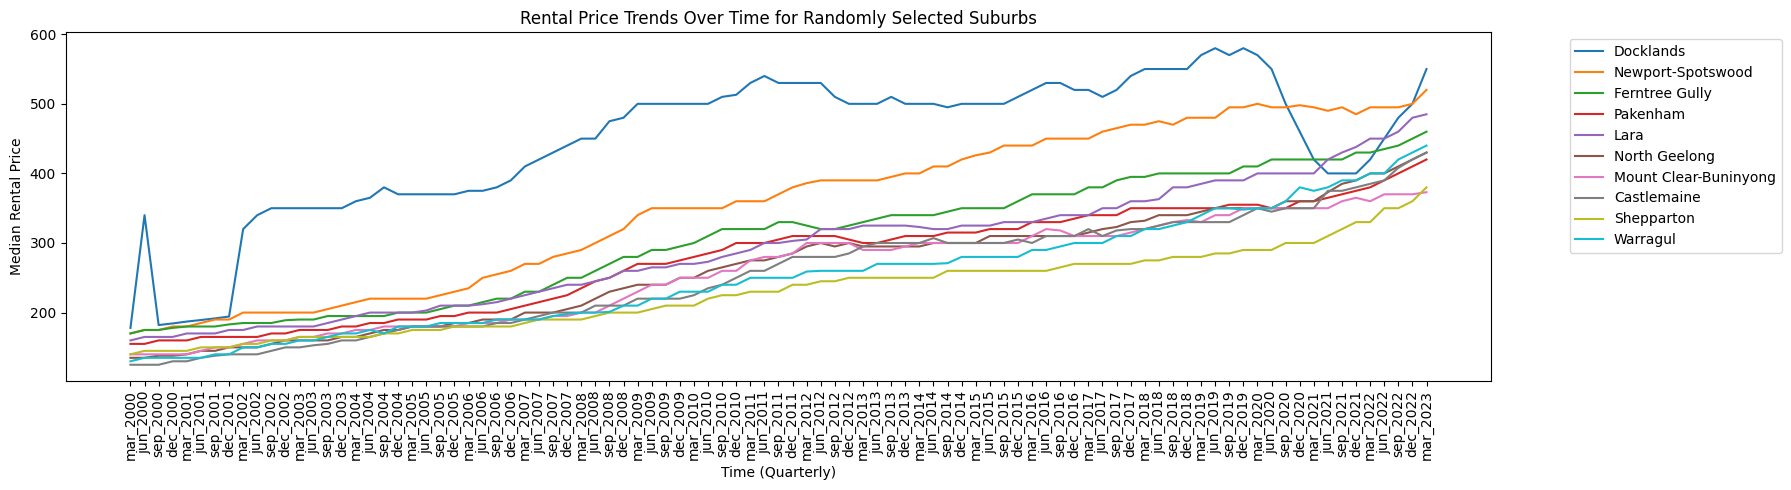

In [41]:
import random
random.seed(1003)  # Set a random seed for reproducibility

# Randomly select 10 suburbs from the 'suburb' column of the DataFrame
random_suburbs = random.sample(list(historical_df['suburb']), 10)

# Filter the DataFrame to include only rows for the randomly selected suburbs
selected_suburbs = historical_df[historical_df['suburb'].isin(random_suburbs)]

# Plot the rental price trends over time for the selected suburbs
plt.figure(figsize=(18, 5))

# Loop through each suburb and plot its data across time (starting from the third column)
for suburb in selected_suburbs['suburb']:
    plt.plot(selected_suburbs.columns[2:], selected_suburbs[selected_suburbs['suburb'] == suburb].values[0][2:], label=suburb)

# Set the plot title and axis labels
plt.title('Rental Price Trends Over Time for Randomly Selected Suburbs')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Median Rental Price')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()

## Observations on Rental Price Trends Plot

This line plot displays the **rental price trends** over time for 10 randomly selected suburbs, showing the **median rental price** across multiple quarters from March 2000 to March 2023.

### Key Insights:
1. **General Upward Trend**: Most suburbs show a steady increase in rental prices over the years, reflecting the general trend of rising rental costs.
   
2. **Sharp Changes**:
   - **Docklands**: This suburb (blue line) has significant volatility, with steep rises between 2003–2010 and a notable decline around 2016–2020.
   - **Newport-Spotswood**: Exhibits more stability but also a sharp rise over the years, making it one of the higher-priced suburbs in this sample.
   
3. **Price Variation**:
   - **Wide Range**: Suburbs like Docklands have much higher median rental prices (peaking around $600) compared to other suburbs such as Warragul and Shepparton, which remain below $400.
   
4. **Flattening in Recent Years**: From 2020 onward, several suburbs show a flattening or slight decrease in rental prices, possibly indicating market adjustments or external factors (such as the pandemic).

5. **Different Growth Rates**: Some suburbs, like **Pakenham** and **Lara**, show moderate and steady growth, while others like **Docklands** experienced rapid fluctuations.

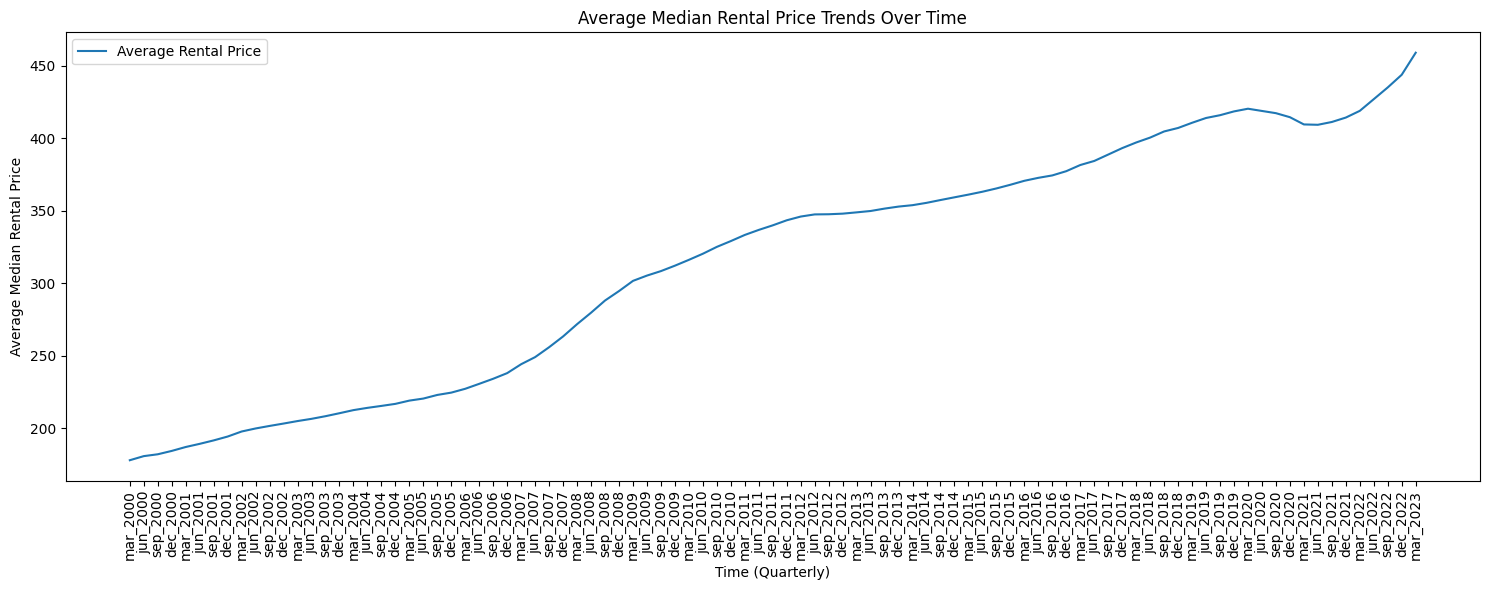

In [42]:
# Calculate the average rental prices for all suburbs over time
average_rental_prices = historical_df.iloc[:, 2:].mean()

# Plotting the average rental price trend over time
plt.figure(figsize=(15, 6))
plt.plot(historical_df.columns[2:], average_rental_prices, label='Average Rental Price')
plt.title('Average Median Rental Price Trends Over Time')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Average Median Rental Price')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## Observations on Average Median Rental Price Trends

1. **Steady Growth**: The average rental price exhibits a consistent upward trend, indicating a continuous increase in rental costs over the years.
   
2. **Periods of Rapid Growth**:
   - Between **2006 and 2010**, rental prices rose sharply, possibly due to economic factors or housing demand surges.
   - Another steep rise is seen from **2021 to 2023**, which could be attributed to post-pandemic market conditions.

3. **Stabilization and Slight Dip**:
   - Around **2017 to 2019**, the growth rate slowed, with a slight dip around 2019–2020. This might be linked to market saturation or other external economic factors.

4. **Recent Price Surge**: Following the slight dip around 2020, rental prices rose again sharply, especially from 2021 to 2023, potentially reflecting inflationary pressures or housing shortages.

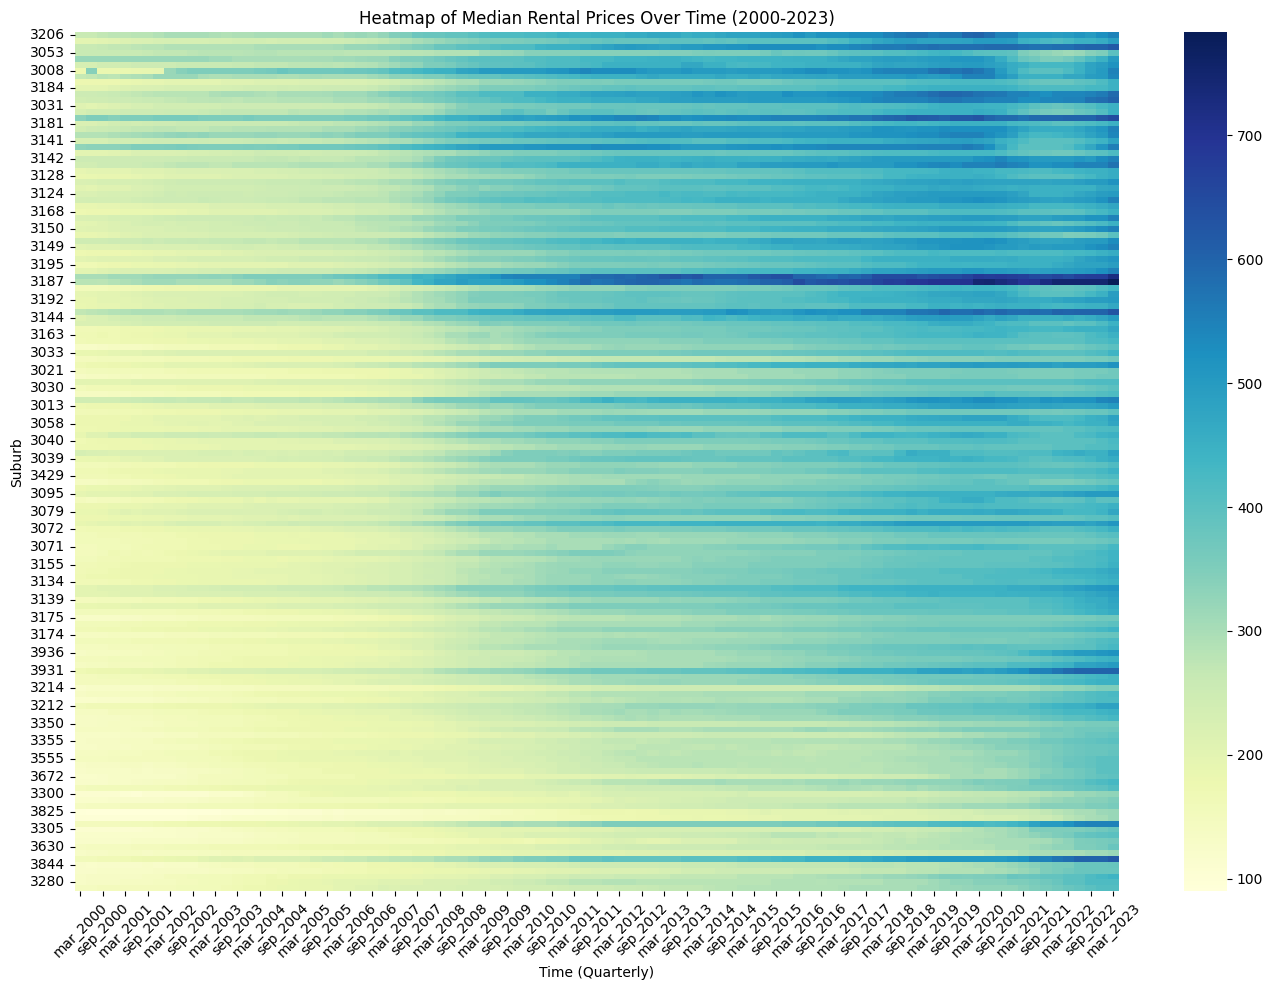

In [43]:
# Create a heatmap for all the suburbs
plt.figure(figsize=(14, 10))

# Exclude the first two columns 'suburb' and 'postcode' for the heatmap
sns.heatmap(historical_df.iloc[:, 2:].set_index(historical_df['postcode']), cmap="YlGnBu", annot=False)
plt.title('Heatmap of Median Rental Prices Over Time (2000-2023)')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Suburb')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Observations on Heatmap of Median Rental Prices (2000-2023)

1. **Upward Price Trend**: The colors shift from lighter (lower rental prices) to darker (higher rental prices) over time, indicating a general increase in rental prices across most suburbs.

2. **Price Clusters**:
   - **Higher Prices (Dark Blue)**: Some suburbs consistently show darker bands, representing higher rental prices, especially in more recent years.
   - **Lower Prices (Lighter Yellow)**: Some suburbs remain lighter, indicating lower rental prices, potentially less affluent or more affordable areas.

3. **Variation Across Suburbs**: While most suburbs see an increase, there is variation in the rate of price growth. Some suburbs experience sharper increases, reaching over $700, while others remain much lower, around $200-$300.

4. **Recent Price Surge**: From around 2020 onwards, a marked increase in prices is visible across many suburbs, suggesting a recent housing market surge or economic factors driving up rental prices.

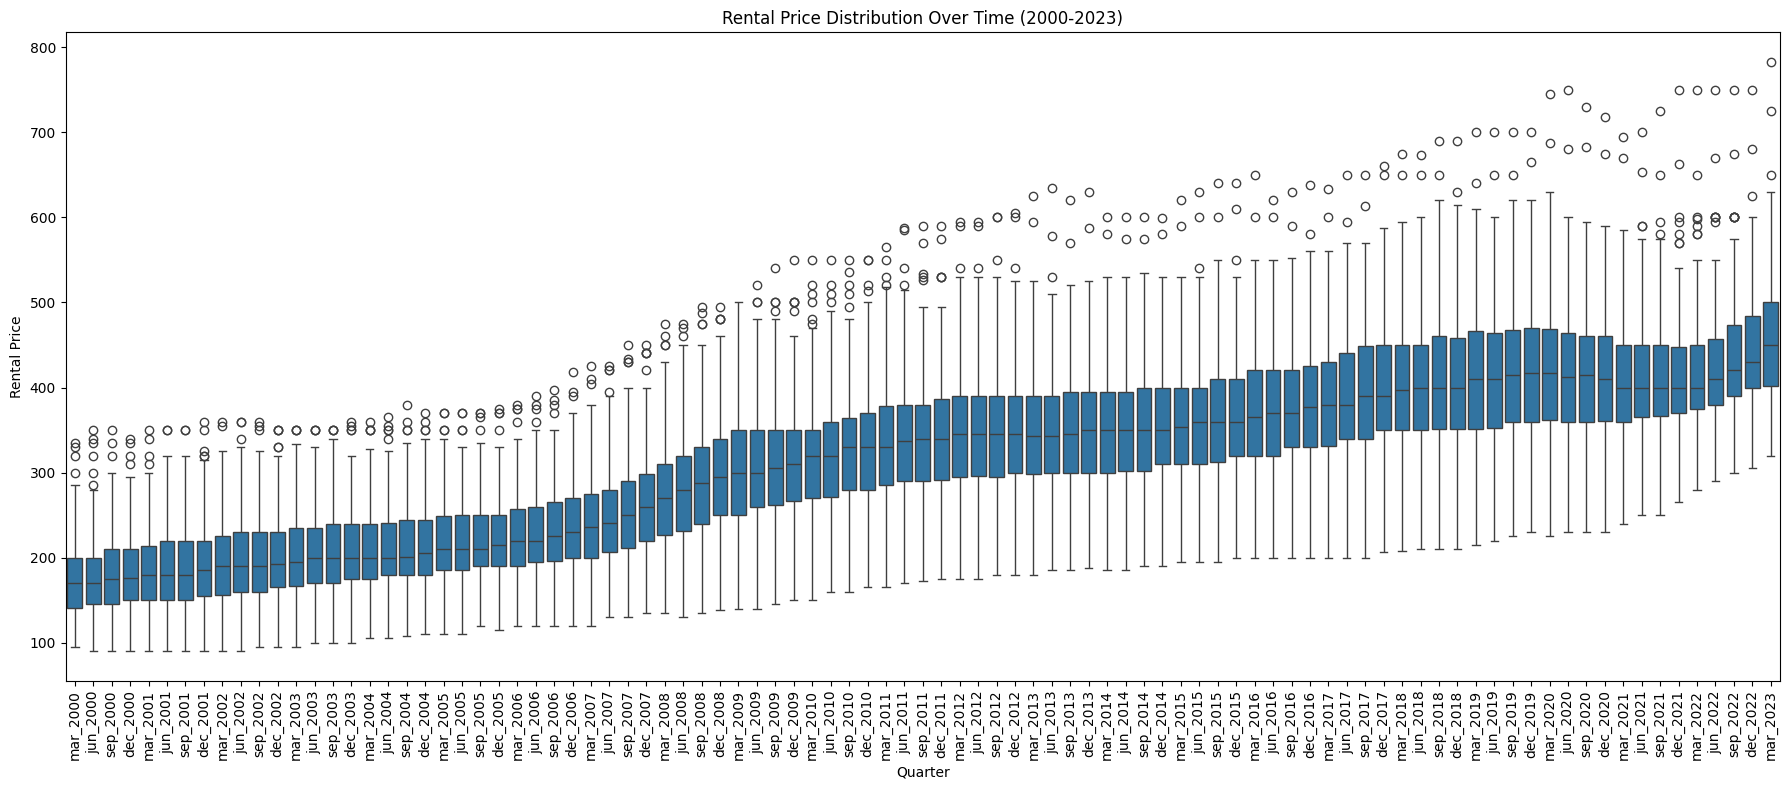

In [44]:
# Transpose the data to make quarters the x-axis
rental_prices_long = historical_df.melt(id_vars=['suburb', 'postcode'], var_name='Quarter', value_name='Rental Price')

# Box plot for rental price distribution over time
plt.figure(figsize=(18, 8))
sns.boxplot(x='Quarter', y='Rental Price', data=rental_prices_long)
plt.title('Rental Price Distribution Over Time (2000-2023)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Observations on Rental Price Distribution Over Time (2000-2023)

1. **Gradual Increase in Median Rental Prices**:
   - The **median** rental prices (horizontal line inside each box) show a steady increase over the years, especially from **2005 to 2023**.
   - This reflects the overall rising trend in rental costs, as seen in the upward movement of the box plots.

2. **Widening Range and Variability**:
   - The **interquartile range (IQR)**, represented by the height of each box, becomes wider over time, indicating increasing variability in rental prices.
   - **2008–2010** shows particularly high variability, possibly reflecting significant changes in the rental market during that period.
   
3. **Outliers**:
   - A growing number of **outliers** (dots above the boxes) appears over time, especially from **2010 onwards**, indicating that some properties are renting for significantly higher prices than the rest.
   - This suggests increasing price disparity across different suburbs or properties.

4. **Impact of External Factors**:
   - There is some noticeable flattening between **2015 and 2020**, suggesting a possible stabilization or slight decline in rental price growth during those years, before rising again post-2020.

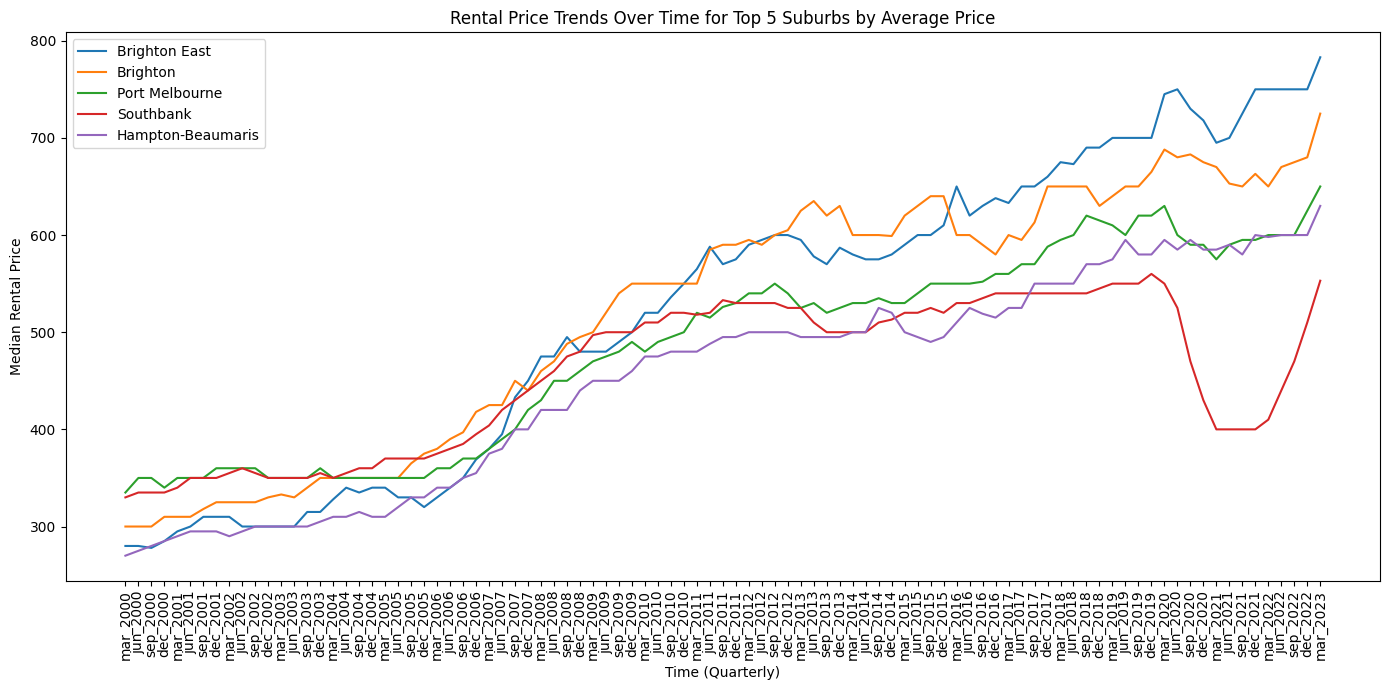

In [45]:
# Calculate the average rental price per suburb
suburb_avg_prices = historical_df.iloc[:, 2:].mean(axis=1)

# Get top 5 suburbs by average rental price
top_5_suburbs = historical_df.loc[suburb_avg_prices.nlargest(5).index]

# Plot the trends for top 5 suburbs
plt.figure(figsize=(14, 7))
for suburb in top_5_suburbs['suburb']:
    plt.plot(historical_df.columns[2:], top_5_suburbs[top_5_suburbs['suburb'] == suburb].values[0][2:], label=suburb)

plt.title('Rental Price Trends Over Time for Top 5 Suburbs by Average Price')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Median Rental Price')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

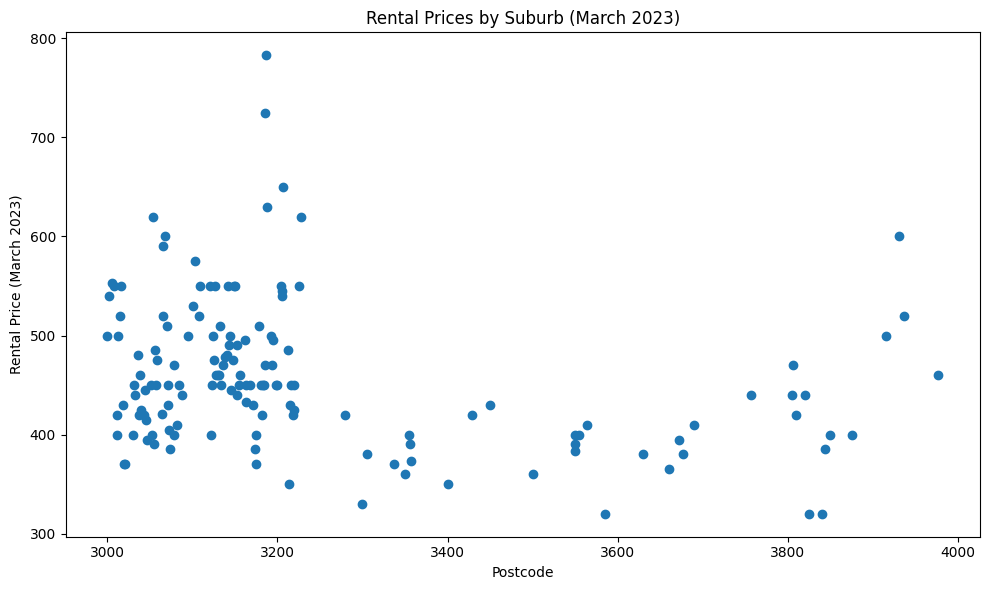

In [46]:
# Scatter plot for rental prices in March 2023 (latest quarter)
plt.figure(figsize=(10, 6))
plt.scatter(historical_df['postcode'], historical_df['mar_2023'])
plt.title('Rental Prices by Suburb (March 2023)')
plt.xlabel('Postcode')
plt.ylabel('Rental Price (March 2023)')
plt.tight_layout()
plt.show()

## Observations on Scatter Plot of Rental Prices by Suburb (March 2023)

1. **Cluster of High Prices**:
   - There is a notable cluster of suburbs with rental prices ranging from **$400 to $600**, particularly concentrated around postcodes **3000 to 3200**.
   - These may represent more central or higher-demand areas where rental prices are generally higher.

2. **Price Outliers**:
   - A few properties stand out with rental prices around **$700 to $800**, indicating that some suburbs have significantly higher rental costs compared to the average.
   - These outliers could be premium locations or exclusive properties.

3. **Lower Rental Prices**:
   - Suburbs with postcodes ranging from **3500 to 4000** generally show lower rental prices, mostly clustered between **$300 and $500**.
   - This suggests these areas may be more affordable or further from central urban locations.

4. **Gradual Increase with Postcode**:
   - There seems to be a slight upward trend in rental prices with increasing postcode numbers, although this is not a strict correlation. Suburbs with lower postcodes (closer to the city) generally have higher prices.

In [47]:
# Create a new column for 12-month price increase rate
def calculate_12_month_rate(row):
    # Take all the values except the first two columns (suburb and postcode)
    price_values = row[2:].values
    # Calculate the percentage change from the same quarter of the previous year (4 steps apart)
    rate_of_change = [(price_values[i] - price_values[i - 4]) / price_values[i - 4] * 100 if i >= 4 and price_values[i - 4] != 0 else np.nan for i in range(len(price_values))]
    return rate_of_change

# Apply the function row-wise to calculate the price increase rate for each suburb
historical_df['annual_increase'] = historical_df.apply(calculate_12_month_rate, axis=1)

# Display the updated dataframe with the new column
historical_df

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,"[nan, nan, nan, nan, 5.769230769230769, 7.6923..."
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,"[nan, nan, nan, nan, 7.5, 10.0, 9.756097560975..."
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,"[nan, nan, nan, nan, 3.8461538461538463, 5.769..."
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,"[nan, nan, nan, nan, 0.0, 0.0, 1.9230769230769..."
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,"[nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0,"[nan, nan, nan, nan, 0.0, 4.166666666666666, 4..."
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0,"[nan, nan, nan, nan, 4.0, 4.0, 0.0, 3.84615384..."
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0,"[nan, nan, nan, nan, 3.8461538461538463, 0.0, ..."
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0,"[nan, nan, nan, nan, 7.6923076923076925, 3.703..."


In [48]:
# Apply a lambda function if any 'annual_increase' entry is missing or invalid, replace it with the mean across valid values.
historical_df['annual_increase'] = historical_df['annual_increase'].apply(lambda x: np.nanmean(x))

# Display the updated DataFrame
historical_df

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,3.210066
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,3.925236
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,3.851826
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,1.559761
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.789150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0,5.266525
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0,5.080689
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0,5.341622
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0,5.292409


In [49]:
# Export the curated historical rental data to a CSV file
historical_df.to_csv("../data/curated/historical_rent.csv", index=False)

In [50]:
# Load the curated historical rental data into a Spark DataFrame
historical_sdf = spark.read.csv("../data/curated/historical_rent.csv", header=True, inferSchema=True)

# Rename the 'suburb' column to 'suburb2' to avoid conflicts with the existing 'suburb' column in the main DataFrame
historical_sdf = historical_sdf.withColumnRenamed("suburb", "suburb2")
historical_sdf

suburb2,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
Albert Park-Middl...,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,300.0,300.0,295.0,290.0,295.0,295.0,300.0,300.0,300.0,300.0,300.0,300.0,310.0,300.0,313.0,320.0,310.0,325.0,345.0,350.0,375.0,380.0,380.0,388.0,390.0,400.0,410.0,420.0,420.0,420.0,425.0,425.0,430.0,445.0,440.0,440.0,450.0,450.0,450.0,460.0,460.0,470.0,470.0,465.0,451.0,460.0,460.0,470.0,480.0,480.0,480.0,490.0,495.0,500.0,520.0,500.0,520.0,520.0,520.0,531.0,530.0,530.0,550.0,560.0,570.0,570.0,552.0,560.0,565.0,595.0,600.0,580.0,550.0,550.0,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,3.210066211663651
Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,233.0,230.0,230.0,230.0,235.0,235.0,240.0,240.0,240.0,235.0,240.0,240.0,240.0,243.0,245.0,245.0,250.0,260.0,265.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,335.0,340.0,350.0,350.0,350.0,353.0,360.0,360.0,365.0,370.0,380.0,380.0,380.0,390.0,385.0,385.0,385.0,385.0,395.0,395.0,395.0,395.0,390.0,395.0,390.0,400.0,400.0,399.0,400.0,400.0,400.0,400.0,400.0,410.0,420.0,440.0,450.0,470.0,480.0,495.0,495.0,480.0,480.0,480.0,480.0,485.0,500.0,500.0,500.0,495.0,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,3.925235787198479
Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,298.0,300.0,300.0,300.0,300.0,300.0,300.0,305.0,320.0,320.0,321.0,330.0,330.0,340.0,350.0,360.0,380.0,380.0,395.0,400.0,400.0,410.0,420.0,420.0,420.0,440.0,450.0,450.0,450.0,460.0,470.0,480.0,495.0,500.0,495.0,490.0,480.0,490.0,500.0,500.0,510.0,510.0,520.0,520.0,530.0,530.0,530.0,530.0,530.0,530.0,520.0,530.0,530.0,540.0,550.0,560.0,562.0,560.0,570.0,573.0,580.0,577.0,580.0,580.0,585.0,590.0,590.0,590.0,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,3.8518257041124078
Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,270.0,270.0,275.0,280.0,280.0,280.0,282.0,284.0,285.0,285.0,280.0,280.0,281.0,280.0,280.0,280.0,275.0,275.0,275.0,275.0,275.0,280.0,280.0,283.0,290.0,290.0,290.0,290.0,310.0,317.0,320.0,325.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,346.0,346.0,346.0,350.0,355.0,351.0,350.0,351.0,351.0,361.0,380.0,370.0,373.0,370.0,370.0,380.0,395.0,397.0,400.0,400.0,410.0,410.0,420.0,428.0,435.0,440.0,430.0,420.0,404.0,400.0,400.0,395.0,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,1.5597610355895246
CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083
Collingwood-Abbot...,3066,230.0,230.0,240.0,240.0,243.0,250.0,250.0,250.0,250.0,260.0,260.0,260.0,260.0,260.0,265.0,265.0,270.0,270.0,270.0,275.

In [51]:
# Perform a left join, keeping all properties from joined_df and attaching relevant historical data from historical_sdf
joined_df2 = joined_df.join(historical_sdf, joined_df['postal_code'] == historical_sdf['postcode'], how='left').drop('postcode', 'suburb2')

# Show the first few rows of the resulting joined DataFrame
joined_df2

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,

In [52]:
# Write to Parquet file
joined_df2.write.parquet("../data/curated/prop_data.parquet", mode="overwrite")

In [53]:
# Load the curated property data from the Parquet file into a Spark DataFrame
sdf = spark.read.parquet("../data/curated/prop_data.parquet")
sdf

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
410/7 katherine p...,https://www.domai...,2,2,NULL,760,NULL,410/7 katherine p...,melbourne,vic,3000,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,22,3.796666666666667,1.5133333333333334,5.745622222222223,2,3.31,1.4,4.6339999999999995,17,2.75,1.0799999999999998,2.9699999999999998,0,8.31,3.0,22.5201,8,3.426666666666667,1.3166666666666667,4.5117777777777786,1,3.32,1.4,4.648,3,4.375,1.65,7.21875,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083
2109/120 a'becket...,https://www.domai...,2,2,NULL,750,NULL,2109/120 a'becket...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,5,2.69,1.0725,2.885025,23,2.174782608695652,0.8843478260869565,1.9232642722117201,0,8.31,3.0,22.5201,11,2.4116666666666666,0.9533333333333335,2.2991222222222225,1,1.94,0.69,1.3385999999999998,0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,

In [54]:
# Read the postcode data using GeoPandas
postcode_data = gpd.read_file('../data/curated/postcode_data').drop(columns=['geometry'])

postcode_data = pd.DataFrame(postcode_data)  # Convert to Pandas DataFrame
postcode_spark_df = spark.createDataFrame(postcode_data)  # Convert Pandas DataFrame to Spark DataFrame

# Display the first few rows of the GeoDataFrame
postcode_spark_df.limit(5)

poa_code,median_inc,mean_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,areasqkm
3000,37178.98796086856,60411.94525842881,2765.1027972198463,3397.0682618193173,3974.3456363159776,4412.431879005364,4941.097475245617,5325.229386523603,5663.613477302199,6035.5852674143025,6511.956555365855,7054.793261296117,7537.803169266871,8503.231610757353,10071.195460070852,11354.612922228534,12495.778158607107,13477.042177746585,14980.66057156676,15930.057692101736,16551.086248741358,16685.739593564667,14337.64704686607,15406.927213875271,17775.11750504633,11.3441226802939,2.4814
3002,81648.0,143914.0,3731.0,3859.0,4243.0,4460.0,4495.0,4555.0,4806.0,5055.0,5202.0,5272.0,5238.0,5280.0,5333.0,5374.0,5411.0,5475.0,5496.0,5412.0,5416.0,5383.0,4959.0,4889.0,5100.0,1.411693203748943,1.8557
3003,54727.0,71654.0,304.95578324229405,316.3300146935193,324.79749810720915,347.2932003107435,366.88215447674247,388.2404335351543,406.43920385711465,432.09441479710046,453.3263135060542,464.82692530673745,471.6514641774726,517.0220096329155,563.7827389323969,611.0489896297106,660.0845652194371,713.0379316423634,768.8980461028251,833.857545724267,896.1630580070896,956.3201043491251,962.2599807736539,1014.3286847503738,1102.5421686720983,7.04130426869316,6.5822
3004,50363.08689048692,88450.25462267414,5088.844744163647,5178.997565888044,5334.992916236908,5450.657247676316,5550.858261366479,5675.256295593804,5827.24166550735,5980.620953670276,6135.533222845449,6249.551924597032,6345.597878810931,6407.91506306864,6467.613248478247,6566.785865553392,6701.491025705475,6845.849645032924,6907.194691843921,6966.71972937164,7071.227781811272,7015.701782433275,6562.519011681803,6597.034656048683,6892.172626807115,2.480865838620039,4.0421
3006,59140.28776312309,81728.07462476981,2290.647146484783,2871.8454571150837,3516.970266911581,3995.514876455665,4406.41640892258,4748.339710955534,5118.449209745571,5431.213958361473,5668.084136739307,5757.216452380307,5776.634234047821,6486.720521280005,7474.982786897191,8101.69272589424,8668.023601941597,9402.343247402847,9996.228704606905,10736.100782577436,11333.692515759656,11575.097178872546,10805.634796457718,11308.45980929208,12219.221156256486,6.339991167672654,1.8542


In [55]:
postcode_spark_df = postcode_spark_df.withColumnRenamed('poa_code', 'postal_code')

# Step 5: Calculate year-on-year percentage increases from 2001 to 2023
population_columns = [f'{year}_pop' for year in range(2001, 2024)]

# Create percentage increase columns
for i in range(1, len(population_columns)):
    prev_col = population_columns[i - 1]
    current_col = population_columns[i]
    increase_col = f'increase_{current_col}'
    postcode_spark_df = postcode_spark_df.withColumn(increase_col, 
        ((F.col(current_col) - F.col(prev_col)) / F.col(prev_col)) * 100)

# Step 6: Calculate the mean of all percentage increases manually
increase_columns = [f'increase_{col}' for col in population_columns[1:]]

# Use the sum of all percentage increase columns and divide by the number of years (to get the mean)
postcode_spark_df = postcode_spark_df.withColumn(
    'mean_population_increase_rate',
    sum([F.col(c) for c in increase_columns]) / len(increase_columns)
)

postcode_spark_df

postal_code,median_inc,mean_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,areasqkm,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate
3000,37178.98796086856,60411.94525842881,2765.1027972198463,3397.0682618193173,3974.3456363159776,4412.431879005364,4941.097475245617,5325.229386523603,5663.613477302199,6035.5852674143025,6511.956555365855,7054.793261296117,7537.803169266871,8503.231610757353,10071.195460070852,11354.612922228534,12495.778158607107,13477.042177746585,14980.66057156676,15930.057692101736,16551.086248741358,16685.739593564667,14337.64704686607,15406.927213875271,17775.11750504633,11.3441226802939,2.4814,22.855044131989466,16.993399308010858,11.022852131589408,11.981274968927632,7.774222492117336,6.354357084315159,6.567746750424231,7.892710762010891,8.336000114788298,6.846549432151821,12.80782238287578,18.43962297028207,12.743447063916413,10.050234597998076,7.8527644031803066,11.156887201132028,6.337485026107123,3.8984702293170783,0.8135619789519815,-14.072451110313422,7.457849698168746,15.370944889246314,9.067308932144892
3002,81648.0,143914.0,3731.0,3859.0,4243.0,4460.0,4495.0,4555.0,4806.0,5055.0,5202.0,5272.0,5238.0,5280.0,5333.0,5374.0,5411.0,5475.0,5496.0,5412.0,5416.0,5383.0,4959.0,4889.0,5100.0,1.411693203748943,1.8557,3.430715625837577,9.950764446747861,5.114305915625737,0.7847533632286996,1.3348164627363739,5.510428100987926,5.181023720349563,2.908011869436202,1.3456362937331794,-0.644916540212443,0.8018327605956471,1.003787878787879,0.7687980498781174,0.6885001860811314,1.1827758270190354,0.3835616438356164,-1.5283842794759825,0.07390983000739099,-0.6093057607090103,-7.876648708898385,-1.4115749142972374,4.315811004295357,1.4867546716177373
3003,54727.0,71654.0,304.95578324229405,316.3300146935193,324.79749810720915,347.2932003107435,366.88215447674247,388.2404335351543,406.43920385711465,432.09441479710046,453.3263135060542,464.82692530673745,471.6514641774726,517.0220096329155,563.7827389323969,611.0489896297106,660.0845652194371,713.0379316423634,768.8980461028251,833.857545724267,896.1630580070896,956.3201043491251,962.2599807736539,1014.3286847503738,1102.5421686720983,7.04130426869316,6.5822,3.7297969332780783,2.6767878545745067,6.926070038910508,5.640465793304219,5.821563899414403,4.687499999999998,6.312189054726375,4.913717461245975,2.536938946194587,1.4681892332789541,9.619506966773859,9.044243461256412,8.383770455054918,8.0248190279214,8.022209458165813,7.83410138248848,8.44838921761999,7.471961200363748,6.7127344521223975,0.6211180124223609,5.411084843708958,8.696735609269878,6.045631513731629
3004,50363.08689048692,88450.25462267414,5088.844744163647,5178.997565888044,5334.992916236908,5450.657247676316,5550.858261366479,5675.256295593804,5827.24166550735,5980.620953670276,6135.533222845449,6249.551924597032,6345.597878810931,6407.91506306864,6467.613248478247,6566.785865553392,6701.491025705475,6845.849645032924,6907.194691843921,6966.71972937164,7071.227781811272,7015.701782433275,6562.519011681803,6597.034656048683,6892.172626807115,2.480865838620039,4.0421,1.7715773669022277,3.0120761472517814,2.168031584210477,1.8383290149620126,2.2410594608967873,2.678035352016542,2.632107898850494,2.5902372073940554,1.8583340291767632,1.5368454470452724,0.9820537867014321,0.9316319711175927,1.533372718266334,2.0513103809078084,2.1541268767460866,0.896091062349088,0.8617831143229088,1.5001041594801998,-0.7852384492664951,-6.459550089289763,0.5259511523766963,4.4

In [56]:
# Drop the 'areasqkm' and 'mean_inc' columns from the DataFrame
postcode_spark_df = postcode_spark_df.drop('areasqkm', 'mean_inc')

# Display the updated DataFrame to confirm that columns are dropped
postcode_spark_df

postal_code,median_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate
3000,37178.98796086856,2765.1027972198463,3397.0682618193173,3974.3456363159776,4412.431879005364,4941.097475245617,5325.229386523603,5663.613477302199,6035.5852674143025,6511.956555365855,7054.793261296117,7537.803169266871,8503.231610757353,10071.195460070852,11354.612922228534,12495.778158607107,13477.042177746585,14980.66057156676,15930.057692101736,16551.086248741358,16685.739593564667,14337.64704686607,15406.927213875271,17775.11750504633,11.3441226802939,22.855044131989466,16.993399308010858,11.022852131589408,11.981274968927632,7.774222492117336,6.354357084315159,6.567746750424231,7.892710762010891,8.336000114788298,6.846549432151821,12.80782238287578,18.43962297028207,12.743447063916413,10.050234597998076,7.8527644031803066,11.156887201132028,6.337485026107123,3.8984702293170783,0.8135619789519815,-14.072451110313422,7.457849698168746,15.370944889246314,9.067308932144892
3002,81648.0,3731.0,3859.0,4243.0,4460.0,4495.0,4555.0,4806.0,5055.0,5202.0,5272.0,5238.0,5280.0,5333.0,5374.0,5411.0,5475.0,5496.0,5412.0,5416.0,5383.0,4959.0,4889.0,5100.0,1.411693203748943,3.430715625837577,9.950764446747861,5.114305915625737,0.7847533632286996,1.3348164627363739,5.510428100987926,5.181023720349563,2.908011869436202,1.3456362937331794,-0.644916540212443,0.8018327605956471,1.003787878787879,0.7687980498781174,0.6885001860811314,1.1827758270190354,0.3835616438356164,-1.5283842794759825,0.07390983000739099,-0.6093057607090103,-7.876648708898385,-1.4115749142972374,4.315811004295357,1.4867546716177373
3003,54727.0,304.95578324229405,316.3300146935193,324.79749810720915,347.2932003107435,366.88215447674247,388.2404335351543,406.43920385711465,432.09441479710046,453.3263135060542,464.82692530673745,471.6514641774726,517.0220096329155,563.7827389323969,611.0489896297106,660.0845652194371,713.0379316423634,768.8980461028251,833.857545724267,896.1630580070896,956.3201043491251,962.2599807736539,1014.3286847503738,1102.5421686720983,7.04130426869316,3.7297969332780783,2.6767878545745067,6.926070038910508,5.640465793304219,5.821563899414403,4.687499999999998,6.312189054726375,4.913717461245975,2.536938946194587,1.4681892332789541,9.619506966773859,9.044243461256412,8.383770455054918,8.0248190279214,8.022209458165813,7.83410138248848,8.44838921761999,7.471961200363748,6.7127344521223975,0.6211180124223609,5.411084843708958,8.696735609269878,6.045631513731629
3004,50363.08689048692,5088.844744163647,5178.997565888044,5334.992916236908,5450.657247676316,5550.858261366479,5675.256295593804,5827.24166550735,5980.620953670276,6135.533222845449,6249.551924597032,6345.597878810931,6407.91506306864,6467.613248478247,6566.785865553392,6701.491025705475,6845.849645032924,6907.194691843921,6966.71972937164,7071.227781811272,7015.701782433275,6562.519011681803,6597.034656048683,6892.172626807115,2.480865838620039,1.7715773669022277,3.0120761472517814,2.168031584210477,1.8383290149620126,2.2410594608967873,2.678035352016542,2.632107898850494,2.5902372073940554,1.8583340291767632,1.5368454470452724,0.9820537867014321,0.9316319711175927,1.533372718266334,2.0513103809078084,2.1541268767460866,0.896091062349088,0.8617831143229088,1.5001041594801998,-0.7852384492664951,-6.459550089289763,0.5259511523766963,4.473797488509873,1.408730349133099
3006,59140.28776312309,2290.647146484783,2871.8454571150837,3516.9

In [57]:
# Write the DataFrame to a Parquet file
postcode_spark_df.write.parquet("../data/curated/postcode_data.parquet", mode="overwrite")

In [58]:
sdf = sdf.join(postcode_spark_df, on="postal_code", how="inner")
sdf

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate
3000,2705/80 a'beckett...,https://www.domai...,1,1,NULL,530,NULL,2705/80 a'beckett...,melbourne,vic,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,0,8.65,2.99,20.8088,6,3.0060000000000002,1.232,3.703392,20,1.9064999999999999,0.785,1.4966025,0,8.31,3.0,22.5201,10,2.098,0.7939999999999998,1.6658119999999994,1,1.75,0.61,1.0675,0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,37178.98796086856,2765.1027972198463,3397.0682618193173,3974.3456363159776,4412.431879005364,4941.097475245617,5325.229386523603,5663.613477302199,6035.5852674143025,6511.956555365855,7054.793261296117,7537.803169266871,8503.231610757353,10071.19546007085

## NULL ANALYSIS

In [59]:
# Calculating the count of nulls in each column
null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])

# Display the count of nulls per column
null_counts

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate
0,0,0,9,9,2192,0,11469,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Key Columns with Potential Nulls:
1. **Location-Based Data**:
   - Columns such as **parks_count**, **schools_count**, and similar columns for other amenities (e.g., **supermarkets**, **hospitals**) could have missing values if data about nearby amenities wasn't available.
   - Travel time and distance columns (e.g., **parks_average_travel_time_mins**, **parks_time_distance_product**) may also have nulls if these values couldn't be computed.

3. **Rental Price Data (2000-2023)**:
   - Rental price data for some years or quarters may be missing for certain postal codes, leading to null values in columns like **mar_2000**, **jun_2000**, and other quarters from 2000 to 2023.
   
4. **Population Data**:
   - Population data across the years (e.g., **2001_pop**, **2002_pop**) may have nulls, especially in cases where population estimates were unavailable.

### Effects of Null Values:
  
- **Incomplete Location Data**: Null values in location-based columns (e.g., **parks_count**, **average_travel_time**) may indicate incomplete data on amenities, impacting analyses related to accessibility and location attractiveness.

- **Incomplete Rental Trends**: Missing rental prices over quarters would limit trend analysis for some postal codes, reducing the dataset's usefulness for time-series analysis in those areas.

- **Missing Population Data**: Nulls in population and growth rate data could affect demographic trend analysis for certain areas.

In [60]:
sdf = sdf.fillna({'unit_floor': 1, 'beds': 1, 'baths': 1, 'parkings': 1, 'street': 'empty'})

In [ ]:
# Get a list of numeric columns (you can specify more columns if needed)
numeric_columns = [column for column, dtype in sdf.dtypes if dtype in ['int', 'double', 'float', 'bigint']]

# Calculate the mean for each numeric column and fill nulls with the corresponding mean
for column in numeric_columns:
    mean_value = sdf.select(F.mean(F.col(column)).alias('mean')).collect()[0]['mean']
    sdf = sdf.fillna(mean_value, subset=[column])

# Show the updated DataFrame
sdf

In [63]:
# Calculating the count of nulls in each column
null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])

# Display the count of nulls per column
null_counts

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
sdf = sdf.dropna()

In [65]:
sdf.write.parquet("../data/curated/prop_cleaned.parquet", mode="overwrite")

In [66]:
sdf = spark.read.parquet("../data/curated/prop_cleaned.parquet")

In [67]:
### Livability Metric creation (Higher score the better, then will standardise? so its a score between 1 and 100)
livability_weight = {"hospitals_count" : 1, "shopping_districts_count": 3, "parks_count": 2, "schools_count": 4, "supermarkets_count": 4, "train_stations_count": 4}

def harmonic_sum(n):
    if n is None or n <= 0:
        return 0.0
    n = int(n)
    return sum(1 / i for i in range(1, n + 1))

# Register the UDF
harmonic_sum_udf = F.udf(harmonic_sum, FloatType())

# Initialize the livability score calculation
livability_score_expr = F.lit(0)  # Start with zero

# Iterate through the weights and create an expression to sum the weighted harmonic sums
for count_col, weight in livability_weight.items():
    if count_col in sdf.columns:
        # Calculate the harmonic sum for the count and multiply by the weight
        livability_score_expr += harmonic_sum_udf(F.col(count_col)) * weight

# Add the livability score as a new column in the DataFrame
sdf = sdf.withColumn("livability_score", livability_score_expr)

# Step 1: Calculate the minimum and maximum livability scores
min_max = sdf.agg(
    F.min("livability_score").alias("min_score"),
    F.max("livability_score").alias("max_score")
).first()

min_score = min_max['min_score']
max_score = min_max['max_score']

# Step 2: Apply min-max normalization to create a new column
if min_score is not None and max_score is not None and min_score != max_score:
    sdf = sdf.withColumn(
        "normalized_livability_score",
        ((F.col("livability_score") - min_score) / (max_score - min_score) * 100).cast("int")
    )
else:
    # If all values are the same, set normalized score to 0 or handle accordingly
    sdf = sdf.withColumn("normalized_livability_score", F.lit(0).cast("int"))

sdf = sdf.drop("livability_score")

# Show the updated DataFrame
sdf.show(truncate=False)


+-----------+-----------------------------------------------------+---------------------------------------------------------------------------------------+----+-----+--------+----+----------+---------------------------------+---------+-----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+-----------+------------------------------+---------------------------------+---------------------------+-------------+--------------------------------+-----------------------------------+-----------------------------+------------------+-------------------------------------+----------------------------------------+----------------------------------+---------------+----------------------------------+-------------

In [68]:
# Define a UDF to calculate the affordability score
def calculate_affordability_score(rent, income):
    if income is None or income == 0:
        return 0  # If income is missing or 0, set score to 0
    rent_to_income_ratio = rent / income
    # Invert the ratio so that lower ratios (more affordable) get higher scores, capped at 100
    score = min(100, max(0, (1 - rent_to_income_ratio) * 100))
    return score

# Register the UDF with FloatType as return type
affordability_score_udf = F.udf(calculate_affordability_score, FloatType())

# Apply the UDF to calculate the affordability score for each row
sdf = sdf.withColumn('affordability_score', affordability_score_udf(F.col('cost'), F.col('median_inc')))

# Show the updated DataFrame with the new 'affordability_score' column
sdf.select('postal_code', 'cost', 'median_inc', 'affordability_score', 'normalized_livability_score').show(truncate=False)

+-----------+----+-----------------+-------------------+---------------------------+
|postal_code|cost|median_inc       |affordability_score|normalized_livability_score|
+-----------+----+-----------------+-------------------+---------------------------+
|3000       |530 |37178.98796086856|98.57446           |69                         |
|3000       |620 |37178.98796086856|98.33239           |91                         |
|3000       |630 |37178.98796086856|98.3055            |67                         |
|3000       |800 |37178.98796086856|97.84824           |91                         |
|3000       |850 |37178.98796086856|97.71376           |69                         |
|3000       |380 |37178.98796086856|98.97792           |73                         |
|3000       |460 |37178.98796086856|98.76274           |84                         |
|3000       |490 |37178.98796086856|98.68205           |94                         |
|3000       |750 |37178.98796086856|97.982735          |86       

In [69]:
# Define the ratio for combining the scores: 7 parts livability and 3 parts affordability
livability_weight = 7
affordability_weight = 3

# Ensure both 'normalized_livability_score' and 'affordability_score' are available in the DataFrame
if 'normalized_livability_score' in sdf.columns and 'affordability_score' in sdf.columns:
    # Calculate the combined score as a weighted sum of livability and affordability
    sdf = sdf.withColumn(
        "combined_score",
        ((F.col("normalized_livability_score") * livability_weight) + 
         (F.col("affordability_score") * affordability_weight)) / (livability_weight + affordability_weight)
    )

# Show the DataFrame with the new combined score
sdf.select('postal_code', 'normalized_livability_score', 'affordability_score', 'combined_score').show(truncate=False)

+-----------+---------------------------+-------------------+-----------------+
|postal_code|normalized_livability_score|affordability_score|combined_score   |
+-----------+---------------------------+-------------------+-----------------+
|3000       |69                         |98.57446           |77.8723388671875 |
|3000       |91                         |98.33239           |93.19971923828125|
|3000       |67                         |98.3055            |76.391650390625  |
|3000       |91                         |97.84824           |93.05447387695312|
|3000       |69                         |97.71376           |77.61412963867187|
|3000       |73                         |98.97792           |80.79337768554687|
|3000       |84                         |98.76274           |88.42882080078125|
|3000       |94                         |98.68205           |95.4046142578125 |
|3000       |86                         |97.982735          |89.59482421875   |
|3000       |84                         

## Livability and Affordability Metric Creation

### Livability Metric

The **Livability Metric** quantifies the quality of life in an area based on proximity to key amenities. The score is normalized between 1 and 100 for comparability across areas.

**Key Steps**:
1. **Weighted Harmonic Sum**:
   - A harmonic sum is calculated for each amenity (e.g., schools, parks), giving diminishing returns as the number of amenities increases.
   - Each amenity is weighted according to its perceived importance (e.g., schools and supermarkets have higher weights than hospitals).

2. **Score Calculation**:
   - The weighted harmonic sums are combined into a **livability score**.
   - Areas with better access to key amenities receive a higher score.

3. **Normalization**:
   - Scores are normalized to a **1-100 scale** using min-max normalization to ensure comparability.
   - If all scores are identical, normalization handles this edge case by assigning a score of 0.

### Affordability Metric

The **Affordability Metric** measures rent affordability based on the rent-to-income ratio, where lower ratios receive higher scores.

**Key Steps**:
1. **Rent-to-Income Ratio**:
   - The ratio of rent (`cost`) to median income (`median_inc`) is calculated for each property.

2. **Score Calculation**:
   - The score is the inverse of the rent-to-income ratio, scaled between **1-100**, with lower ratios receiving higher scores.
   - The score is capped at **100** and set to **0** if income data is missing or zero.

### Combined Score

A **Combined Score** is calculated by weighting **livability** and **affordability** in a **7:3 ratio**, reflecting the greater importance of livability factors such as access to amenities while still considering financial accessibility.

**Why this approach?**:
1. **Balancing Livability and Affordability**: Livability contributes more to the overall quality of life, so it is weighted more heavily. Affordability is important but receives a smaller weight to ensure that areas with lower rent don't dominate the ranking.
2. **Weighted Average**: The combined score ensures that both factors are considered in proportion, allowing for a more holistic evaluation of each property.

The combined score is also normalized to a **1-100 scale** for consistency and ease of comparison.

In [70]:
sdf

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,pop_growth,increase_2002_pop,increase_2003_pop,increase_2004_pop,increase_2005_pop,increase_2006_pop,increase_2007_pop,increase_2008_pop,increase_2009_pop,increase_2010_pop,increase_2011_pop,increase_2012_pop,increase_2013_pop,increase_2014_pop,increase_2015_pop,increase_2016_pop,increase_2017_pop,increase_2018_pop,increase_2019_pop,increase_2020_pop,increase_2021_pop,increase_2022_pop,increase_2023_pop,mean_population_increase_rate,normalized_livability_score,affordability_score,combined_score
3000,2705/80 a'beckett...,https://www.domai...,1,1,1,530,1,2705/80 a'beckett...,melbourne,vic,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,0,8.65,2.99,20.8088,6,3.0060000000000002,1.232,3.703392,20,1.9064999999999999,0.785,1.4966025,0,8.31,3.0,22.5201,10,2.098,0.7939999999999998,1.6658119999999994,1,1.75,0.61,1.0675,0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,37178.98796086856,2765.1027972198463,3397.0682618193173,3974.3456363159776,4412.431879005364,4941.097475245617,5325.229386523603,5663.613477302199,6035.5852674143025,6511.956555365855,7054.793261296

In [71]:
sdf.write.parquet("../data/curated/prop_cleaned1.parquet", mode="overwrite")

In [81]:
# Read the Excel file into a Pandas DataFrame
housing_price_df = pd.read_excel("../data/raw/housing_price.xls")

# Convert the Pandas DataFrame to a Spark DataFrame
housing_price_sdf = spark.createDataFrame(housing_price_df)

# Display the Spark DataFrame
housing_price_sdf

AttributeError: 'NoneType' object has no attribute 'sc'

In [73]:
# Extract postcode using regular expression, convert to integer
df_cleaned = housing_price_sdf.withColumn("postcode", regexp_extract(col("postcode"), r'(\d{4})$', 1).cast(IntegerType()))

# Drop the original 'postcode' column if needed
df_cleaned = df_cleaned.drop("locality")

# Show the cleaned dataframe after dropping the column
df_cleaned

postcode,2023_q1,2023_12,2023_q3,2023_q4,2024_q1
3067,1412000,1005000,1280000,1283800,1190000
3040,1535500,1820300,1550000,1540000,1805000
3336,735500,735000,800100,735000,750000
3231,1570000,1900000,1745000,1587500,1605000
3042,892500,955000,920000,967500,967500
3021,590000,587500,600000,638000,625000
3206,2098500,2500000,2275000,2350000,2197500
3020,645000,800000,765000,765000,715000
3714,459500,468000,520000,471000,495000
3350,640000,668500,610000,660000,620000


In [86]:
# Ensure that the 'postal_code' column in both DataFrames is of the same type (integer)
sdf = sdf.withColumn("postal_code", sdf["postal_code"].cast(IntegerType()))
df_cleaned = df_cleaned.withColumn("postal_code", df_cleaned["postal_code"].cast(IntegerType()))

# Perform a left join between 'sdf' and 'df_cleaned' on 'postal_code'
sdf_joined = sdf.join(df_cleaned, on="postal_code", how="left")

# Show the resulting DataFrame after the join
sdf_joined

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `postal_code` cannot be resolved. Did you mean one of the following? [`postcode`, `2023_q1`, `2023_12`, `2023_q3`, `2023_q4`, `2024_q1`].

In [89]:
df_cleaned = df_cleaned.withColumnRenamed("postcode", "postal_code")

# Perform a left join between 'sdf' and 'df_cleaned' on 'postal_code'
sdf = sdf.join(df_cleaned, on="postal_code", how="left")

# Show the resulting DataFrame after the join
sdf

Py4JJavaError: An error occurred while calling o6031.showString.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2707)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:61)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:58)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:34)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$2(AdaptiveSparkPlanExec.scala:169)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:168)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:588)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:538)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:277)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:272)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:417)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at sun.reflect.GeneratedMethodAccessor88.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


Py4JJavaError: An error occurred while calling o6031.htmlString.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2707)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:61)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:58)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:34)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$2(AdaptiveSparkPlanExec.scala:169)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:168)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:588)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:538)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:277)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:272)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:417)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.htmlString(Dataset.scala:409)
	at sun.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [74]:
spark.stop()